**Implementation of CP-ALS Tensor Algorithm**

Make sure to import necessary packages for the this implementation 

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensortools as tt
from tensortools.operations import khatri_rao
import tensorly as tl
from tensorly import unfold
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.io import loadmat

*Defining Key functions*  

In [19]:
def update_factor_matrix(X_unfolded, other_factors, reg=1e-5):
    """
    Update a factor matrix A following the CP-ALS algorithm using the pseudo-inverse.

    Parameters:
    - X_unfolded: The unfolded tensor along the mode corresponding to the factor matrix A.
    - other_factors: List of other factor matrices, not including A.

    Returns:
    - Updated factor matrix
    """
    # Compute the Khatri-Rao product of the other factor matrices
    kr_product = khatri_rao(other_factors)
    
    NUM = tf.linalg.pinv((tf.transpose(other_factors[0]) @ other_factors[0]) * (tf.transpose(other_factors[1]) @ other_factors[1]))
    
    return X_unfolded @ kr_product @ NUM

In [20]:
def compute_reconstructed_tensor(A,B,C):
    """
    Combines the factor matrices A, B, C after training to get the final tensor

    Parameters: 
    - A, B, C are the factor matrices

    Returns
    -Reconstructed Tensor
    """
    factor_matrices = [A,B,C]

    # Multiply by the remaining factor matrices
    reconstructed_tensor = tf.einsum('az,bz,cz->abc', factor_matrices[0], factor_matrices[1], factor_matrices[2])
    return reconstructed_tensor

In [34]:
def cp_als_update(X, rank, epochs):
    """
    Perform ALS updates for CP decomposition.

    Parameters: 
    -X is a tensor 
    -Rank 
    -Epochs is the max iterations for your training

    Returns: 
    - Factor matrices A,B,C from training 
    -Error for the objective 
    -Reconstructed Tensor
    
    """
    np.random.seed(2)
    factors = [np.random.rand(X.shape[i], rank) for i in range(3)]
    
    A, B, C = factors
    
    error_list = []

    for _ in range(epochs):
        # Update A
        A = update_factor_matrix(unfold(X, 0), [B, C])

        # Update B
        B = update_factor_matrix(unfold(X, 1), [A, C])

        # Update C
        C = update_factor_matrix(unfold(X, 2), [A, B])

        reconstructed = compute_reconstructed_tensor(A,B,C)
        error = X - reconstructed
        error_list.append(tf.linalg.norm(error))
        
        

    return A, B, C, error_list, reconstructed

*Loading the Data*

In [22]:
data = loadmat('amino.mat')
data["X"].shape
#tensor = data["X"]

# Example usage:
X = data["X"]

*Performing the CP-ALS Tensor Decomposition*

In [35]:
A, B, C, error_list, X_recon = cp_als_update(X,3,50)

*Plotting the Error Loss For the Objective Function*

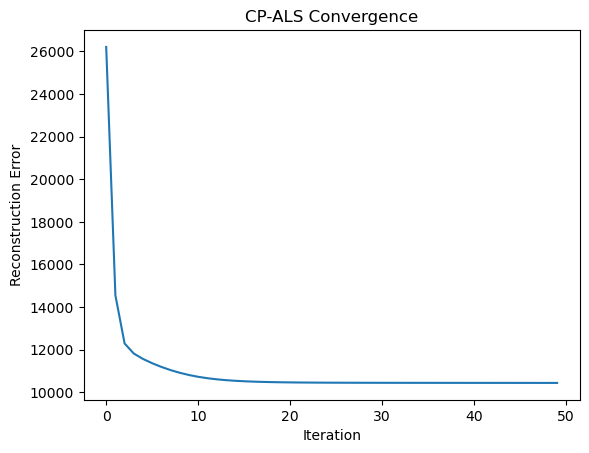

In [46]:
plt.plot(error_list)
plt.xlabel('Iteration')
plt.ylabel('Reconstruction Error')
plt.title('CP-ALS Convergence')
plt.savefig("Decomp_error")

In [33]:
factors = [A,B,C]

*Fit Metric for Assessing Quality of the Decomposition*

In [37]:
def fit_decon(X, X_recon):
    return 1 - tf.math.reduce_sum(X - X_recon) / tf.math.reduce_sum(X)
    

In [38]:
fit = fit_decon(X, X_recon)
print(fit)

tf.Tensor(0.9975863797502554, shape=(), dtype=float64)


In [40]:
tf.transpose(A) @ data["Y"]

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[0.0002772 , 0.00331351, 0.1982136 ],
       [0.00029848, 0.00331586, 0.22777011],
       [0.0015709 , 0.00248238, 0.11988793]])>

In [42]:
def calculate_correlation_matrix(A, Y):
    correlation_matrix = np.zeros((A.shape[1], Y.shape[1]))
    
    for i in range(A.shape[1]):
        for j in range(Y.shape[1]):
            if np.std(A[:, i]) != 0 and np.std(Y[:, j]) != 0:  # Check if the standard deviation is not zero
                correlation_matrix[i, j] = np.corrcoef(A[:, i], Y[:, j])[0, 1]
            else:
                correlation_matrix[i, j] = 0  # If the standard deviation is zero, correlation is undefined
                
    return correlation_matrix

In [44]:
calculate_correlation_matrix(A, data['Y'])

array([[-0.89495846,  0.62677271,  0.36927699],
       [-0.90292421,  0.47838828,  0.52824785],
       [ 0.99410288, -0.36153224, -0.5525666 ]])